## Импорты

In [ ]:
!pip install nltk

In [2]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
!pip install plotly.express

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install pymorphy3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [40]:
import pandas as pd
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import pytz
import gensim
import pyLDAvis.gensim_models
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
import pymorphy3
import inspect
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
nltk.download('punkt')
from tqdm import tqdm
from gensim.models import LdaMulticore, CoherenceModel
from gensim.models import Phrases

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lldckv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lldckv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lldckv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Обработка данных

In [8]:
# Данные с информацией о видео
video_data = pd.read_csv('video_data_for_lda.csv')
video_data.head()

,rutube_video_id,title
0,video_10,Разлука Орхидеи и Повелителя демонов- 1 сезон ...
1,video_10000,Как корабль эпохи Петра Великого нашли на дне ...
2,video_100001,Этой БМВ уже не помочь :( Пора сдаваться…
3,video_100002,КРИМИНАЛЬНАЯ РОССИЯ - ТАЙНА НЕВСКОГО ЛЕСОПАРКА
4,video_100006,"Электро шоу-электроарфы, электроскрипки, труба..."


In [9]:
analyzer = pymorphy3.MorphAnalyzer()

In [12]:
def text_to_wordlist(text: tp.List[str], remove_stopwords: bool=False, bi: bool=False) -> tp.List[str]:
    text = re.sub(r'[^а-яА-ЯёЁa-zA-Z]', " ", text)
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    norm_words = [analyzer.parse(word)[0].normal_form for word in words]
    if remove_stopwords:
        stops = stopwords.words("russian") + ["серия", "сезон", "смотреть", "бесплатно", "фильм",
                                              "новый", "часть", "мульсериал", "кино", "последний",
                                              "озвучка", "шоу", "выпуск", "сериал"]
        if not bi:
            stops = stops + ['and', 'the']
        norm_words = [w for w in norm_words if w not in stops]
    norm_words = [w for w in norm_words if len(w) >= 3]

    return norm_words

In [22]:
video_data["content"] = video_data.apply(lambda row: text_to_wordlist(row["title"], remove_stopwords=True), axis=1)
video_data.head()

,rutube_video_id,title,content
0,video_10,Разлука Орхидеи и Повелителя демонов- 1 сезон ...,"[разлука, орхидея, повелитель, демон, love, be..."
1,video_10000,Как корабль эпохи Петра Великого нашли на дне ...,"[корабль, эпоха, пётр, великий, наслать, день,..."
2,video_100001,Этой БМВ уже не помочь :( Пора сдаваться…,"[бмв, помочь, пора, сдаваться]"
3,video_100002,КРИМИНАЛЬНАЯ РОССИЯ - ТАЙНА НЕВСКОГО ЛЕСОПАРКА,"[криминальный, россия, тайна, невский, лесопарк]"
4,video_100006,"Электро шоу-электроарфы, электроскрипки, труба...","[электро, электроарфа, электроскрипка, труба, ..."


### LDA с униграммами

In [41]:
id2word_uni = corpora.Dictionary(video_data["content"].tolist())
texts = video_data["content"].tolist()
corpus_uni = [id2word_uni.doc2bow(text) for text in texts]

In [44]:
st=2
lim=20
stp=2


def compute_coherence_values(dictionary, corp, texts, start:int=st, limit:int = lim, step:int=stp):
    """
	Подсчет c_v когерентности для различного количества тем
	dictionary : Gensim словарь
	corpus : Gensim корпус
	texts : Список текста
	limit : Максимальное количество тем

	model_list : Список LDA моделей
	coherence_values :Когерентности, соответствующие модели LDA с количеством тем
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corp,id2word=dictionary, num_topics=num_topics, random_state=np.random.RandomState(42))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


In [51]:
model_list_uni, coherence_values_uni = compute_coherence_values(dictionary=id2word_uni, corp=corpus_uni, texts=texts)

100%|█████████████████████████████████████████████| 9/9 [02:21<00:00, 15.71s/it]


In [52]:
def plot_coherence_values(coherence_values: np.array, start:int=st, limit:int = lim, step:int=stp, bi:bool=False):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    if bi:
        name = 'Биграммы'
    else:
        name = 'Униграммы'
    plt.xlabel(f"Количество тем: {name}")
    plt.ylabel("Согласованность")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    return x[coherence_values_uni.index(max(coherence_values_uni))]


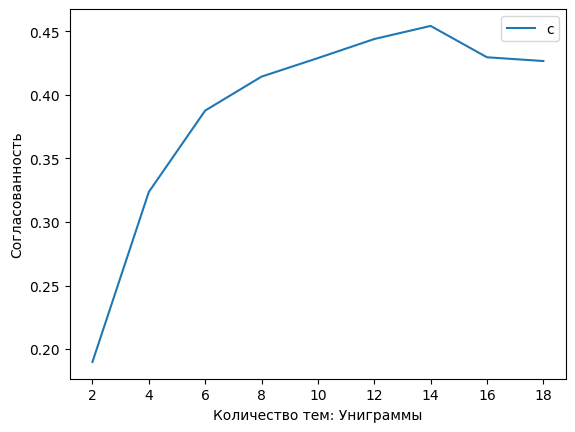

In [54]:
n_topics_uni = plot_coherence_values(coherence_values=coherence_values_uni)

In [55]:
lda_model_uni = LdaMulticore(corpus=corpus_uni, id2word=id2word_uni, num_topics=n_topics_uni)
lda_model_uni.print_topics()[:3]

[(0,
  '0.012*"мир" + 0.010*"хороший" + 0.009*"аниме" + 0.007*"сказка" + 0.007*"история" + 0.007*"ночь" + 0.006*"мультсериал" + 0.005*"дело" + 0.005*"девушка" + 0.005*"война"'),
 (1,
  '0.011*"звезда" + 0.010*"год" + 0.007*"плохой" + 0.006*"воскреснуть" + 0.006*"бывать" + 0.005*"эртугрула" + 0.005*"обзор" + 0.005*"ждать" + 0.005*"middle" + 0.004*"викинг"'),
 (2,
  '0.013*"симпсон" + 0.013*"simpsons" + 0.012*"битва" + 0.010*"мама" + 0.010*"аниме" + 0.009*"тайна" + 0.009*"ваш" + 0.007*"встретить" + 0.007*"экстрасенс" + 0.007*"война"')]

In [56]:
pyLDAvis.enable_notebook()
LDAvis_prepared_uni = pyLDAvis.gensim_models.prepare(lda_model_uni, corpus_uni, id2word_uni)

In [66]:
# pyLDAvis.save_html(LDAvis_prepared_uni, 'lda_visualization_unigram.html')

In [57]:
LDAvis_prepared_uni

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.243551 -0.034218       1        1  8.400036
7      0.063311 -0.038220       2        1  7.875347
3      0.036188 -0.004810       3        1  7.870507
2      0.047961  0.014080       4        1  7.358004
8      0.058557  0.165935       5        1  7.233069
6      0.049076 -0.067247       6        1  7.190734
13    -0.078108  0.127208       7        1  7.123092
11     0.048543 -0.101477       8        1  7.026764
9     -0.015981 -0.070526       9        1  6.900908
0      0.056344  0.018490      10        1  6.874449
12    -0.138144 -0.019446      11        1  6.628398
1      0.054748 -0.106157      12        1  6.612840
10     0.039713  0.027366      13        1  6.489446
5      0.021343  0.089023      14        1  6.416407, topic_info=          Term         Freq        Total Category  logprob  loglift
38        эфир  2898.000000  2898.000000  Default  30.0000  30.0000
13        день  3945.000000  3945.000000  Default  29.0000  29.0000
35       город  2773.000000  2773.000000  Default  28.0000  28.0000
36         дом  4242.000000  4242.000000  Default  27.0000  27.0000
34    вечерний  2365.000000  2365.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
46     jaskier   113.151821   818.087628  Topic14  -5.8399   0.7681
102        год   143.314896  2707.935217  Topic14  -5.6036  -0.1926
124    история   129.726668  2505.287610  Topic14  -5.7032  -0.2144
233      обзор   114.544972  2410.814593  Topic14  -5.8277  -0.3004
1534    музыка   108.542910  1506.502628  Topic14  -5.8815   0.1159

[1210 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1454       1  0.043517  adventures
1454       3  0.029011  adventures
1454       4  0.841322  adventures
1454       5  0.014506  adventures
1454       6  0.029011  adventures
...      ...       ...         ...
1995      14  0.042368       южный
3319      11  0.960590      юрмала
13671      2  0.935902      яблоня
23643     14  0.919402    янтарный
18723      1  0.909433   ярославль

[6039 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 4, 3, 9, 7, 14, 12, 10, 1, 13, 2, 11, 6])

### LDA с биграммами

In [60]:
bigram = Phrases(texts, min_count=2, threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts_with_bigrams = [bigram_mod[text] for text in texts]

id2word_b = corpora.Dictionary(texts_with_bigrams)
corpus_b = [id2word_b.doc2bow(text) for text in texts_with_bigrams]
model_list_b, coherence_values_b = compute_coherence_values(dictionary=id2word_b, corp=corpus_b, texts=texts_with_bigrams, start=2, limit=20, step=2)

100%|█████████████████████████████████████████████| 9/9 [02:19<00:00, 15.50s/it]


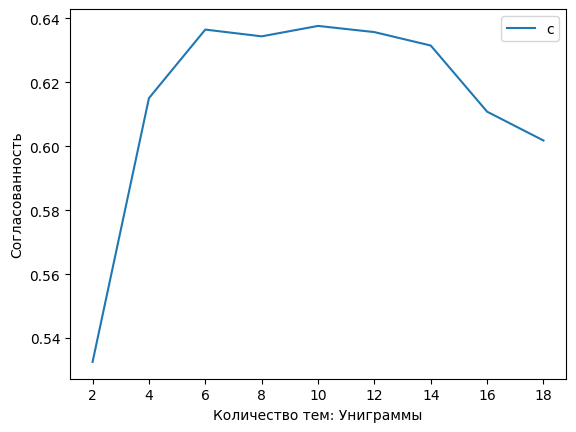

In [59]:
n_topics_b = plot_coherence_values(coherence_values=coherence_values_b)

In [62]:
lda_model_b = LdaMulticore(corpus=corpus_b, id2word=id2word_b, num_topics=n_topics_b)
lda_model_b.print_topics()[:3]

[(0,
  '0.016*"следствие_вели" + 0.007*"танец" + 0.007*"зачаровать" + 0.006*"школа" + 0.006*"ночь" + 0.006*"мама" + 0.005*"эфир" + 0.005*"дом_lite" + 0.005*"день_дневный" + 0.005*"аниме"'),
 (1,
  '0.017*"любовь" + 0.006*"россия" + 0.005*"секрет_миллион" + 0.005*"спасти_свой" + 0.005*"аниме" + 0.004*"драматичный_момент" + 0.004*"женский_самый" + 0.003*"дело_несовершеннолетний" + 0.003*"луна" + 0.003*"мужской_женский"'),
 (2,
  '0.015*"симпсон_simpsons" + 0.010*"аниме" + 0.010*"секретный_материал" + 0.008*"история" + 0.006*"люцифер" + 0.006*"files" + 0.005*"герой" + 0.005*"ван_пис" + 0.005*"бумажный_дом" + 0.004*"урок"')]

In [63]:
pyLDAvis.enable_notebook()
LDAvis_prepared_b = pyLDAvis.gensim_models.prepare(lda_model_b, corpus_b, id2word_b)

In [68]:
# pyLDAvis.save_html(LDAvis_prepared_b, 'lda_visualization_bigram.html')

In [65]:
LDAvis_prepared_b

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.003213  0.160387       1        1  7.365552
7      0.097445 -0.045052       2        1  7.351186
12    -0.023838  0.003433       3        1  7.341154
2      0.035434 -0.124650       4        1  7.283031
5     -0.019117  0.127373       5        1  7.237833
0      0.010557 -0.030005       6        1  7.201356
6      0.046723  0.048525       7        1  7.143271
13     0.076431  0.042696       8        1  7.139112
10    -0.025525 -0.109834       9        1  7.126920
3     -0.270948 -0.024896      10        1  7.101705
1      0.045119 -0.005529      11        1  7.098671
9     -0.030777 -0.036290      12        1  7.031582
11    -0.004486  0.069312      13        1  6.897727
8      0.059769 -0.075471      14        1  6.680900, topic_info=                  Term         Freq        Total Category  logprob  loglift
28         любовь_день  2128.000000  2128.000000  Default  30.0000  30.0000
27           дом_город  2129.000000  2129.000000  Default  29.0000  29.0000
26       вечерний_эфир  2113.000000  2113.000000  Default  28.0000  28.0000
419   симпсон_simpsons   531.000000   531.000000  Default  27.0000  27.0000
32      следствие_вели   640.000000   640.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
124                всё    71.337810   822.035623  Topic14  -6.0762   0.2616
217    мужской_женский    73.250878  1663.864970  Topic14  -6.0497  -0.4171
716             любовь    64.796481  1008.732011  Topic14  -6.1724  -0.0393
263             минута    57.978848   369.532448  Topic14  -6.2835   0.8538
1147           сделать    54.416268   438.008291  Topic14  -6.3469   0.6203

[1082 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
4931       2  0.044780  amsterdam
4931       6  0.044780  amsterdam
4931       7  0.862011  amsterdam
4931       8  0.022390  amsterdam
4931      14  0.022390  amsterdam
...      ...       ...        ...
521       10  0.032296       юмор
521       11  0.016148       юмор
521       13  0.032296       юмор
3246       6  0.911876     юрмала
23363     11  0.927707  ярославль

[4587 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 13, 3, 6, 1, 7, 14, 11, 4, 2, 10, 12, 9])